# ECG Processing

In [16]:
#import libraries


import numpy as np
import pandas as pd
import os
import scipy
from scipy.signal import butter, filtfilt, iirnotch, find_peaks

import matplotlib.pyplot as plt

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')
# # Set your own specific drive path
ROOT_PATH   = os.path.dirname(os.getcwd())
DATA_FOLDER   = os.path.join(ROOT_PATH, "Data")
DATA_Batch_01 = os.path.join(DATA_FOLDER, "01_batch_ECG_Signals")
DATA_Batch_02 = os.path.join(DATA_FOLDER, "02_batch_ECG_Signals")

In [18]:
# prepare functions for filtering
# basic ECG preprocessing

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=1000, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=1000, quality_factor=30):
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data)

In [19]:
#import the data and filter the signals
# This could be change depending if you download or not the data

#ECG_folder = "/content/drive/MyDrive/WP_02_data/1_batch_extracted"
#ECG_folder_2batch = "/content/drive/MyDrive/WP_02_data/2_batch_extracted"

filename_Batch_01     = f"{DATA_FOLDER}\\VALETUDO_database_1st_batch_en_all_info.xlsx"
filename_Batch_02     = f"{DATA_FOLDER}\\VALETUDO_database_2nd_batch_en_all_info.xlsx"
tabular_data_Batch_01 = pd.read_excel(filename_Batch_01)
tabular_data_Batch_02 = pd.read_excel(filename_Batch_02)

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(DATA_Batch_01) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(DATA_Batch_02) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))
signals_2 = np.empty((len(ECGs_2), 5000, 12))

for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(DATA_Batch_01, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_1[index, :, :] = ecg

for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(DATA_Batch_02, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg

# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data_Batch_01.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_Batch_02.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)



Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 19)


In [20]:
print(f"nb pos: {np.sum(tabular_data_Batch_01['sport_ability']==1)}")
print(f"% pos: {np.sum(tabular_data_Batch_01['sport_ability']==1)/len(tabular_data_Batch_01['sport_ability'])*100:.2f}%")

nb pos: 107
% pos: 56.02%


In [21]:
tabular_data_Batch_01

,code,ECG_patient_id,age_at_exam,sex,weight,height,trainning_load,sport_classification,sport_ability,AV block,ST abnormality,Complete BBB,Prolonged QTc,Uncontrolled hypertension,Supraventricular arrhythmias,Ventricular arrhythmias,Baseline ECG abnormalities,Valvular heart diseases,Symptomatic patients
0,1,3,20.095825,0,60.0,166.0,2,1,0,0,0,0,0,0,0,1,0,0,0
1,2,4,51.646817,0,84.0,180.0,2,1,0,0,1,0,0,1,0,0,0,0,0
2,3,5,40.936345,0,104.0,180.0,1,1,0,0,0,0,0,0,0,1,0,0,0
3,4,6,14.201232,0,80.0,174.0,2,1,1,0,0,0,0,0,0,0,0,0,0
4,5,7,16.607803,1,47.0,148.0,2,1,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,187,210,22.228611,0,73.0,185.0,2,1,1,0,0,0,0,0,0,0,0,0,0
187,188,211,18.190281,0,60.0,172.0,2,1,1,0,0,0,0,0,0,0,0,0,0
188,189,212,50.332649,1,70.0,168.0,1,0,1,0,0,0,0,0,0,0,0,0,0
189,190,213,27.646817,1,50.0,159.0,2,1,1,0,0,0,0,0,0,0,0,0,0


3.925195445306439


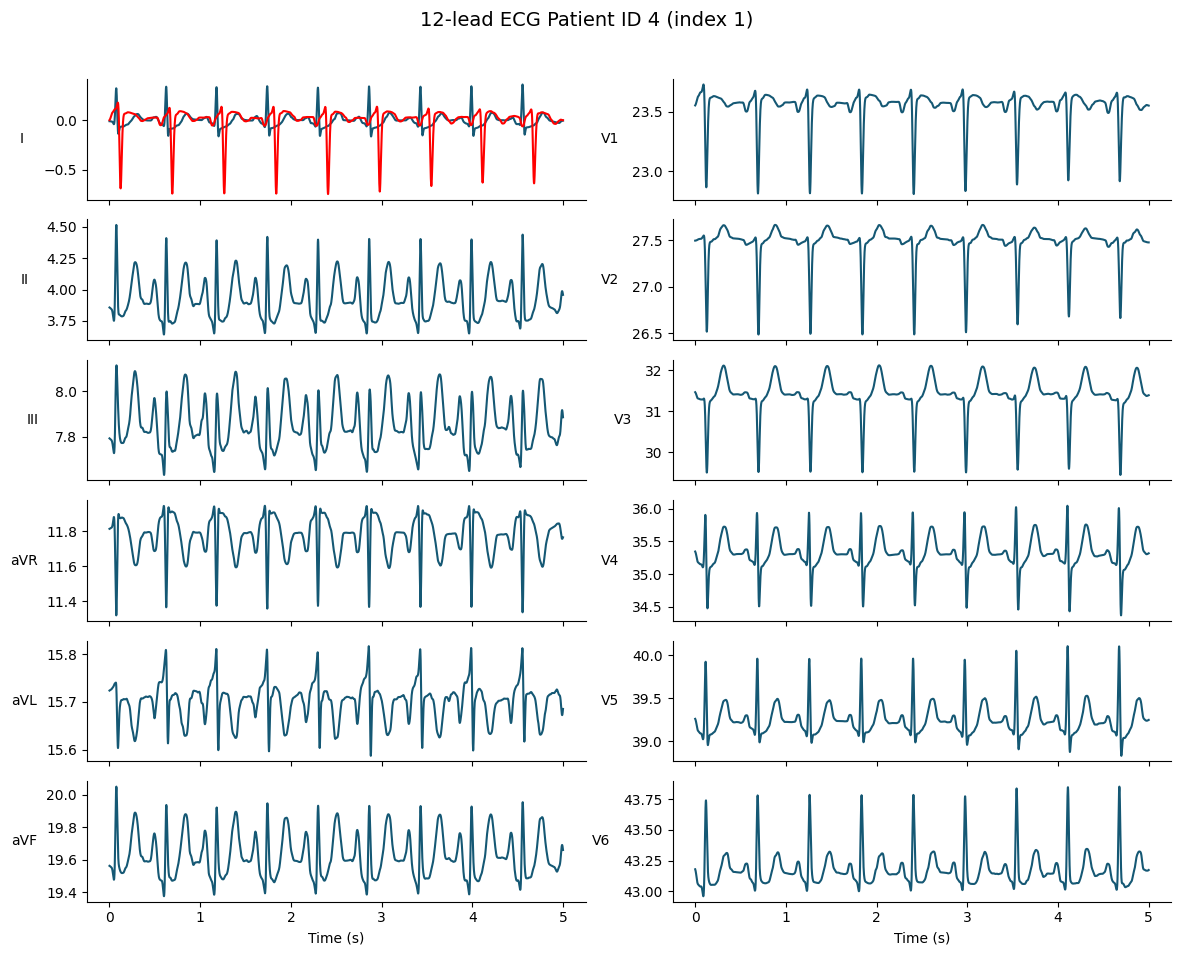

In [22]:
def plot_12lead_for_patient(patient_id, signals, tabular_data, fs=500):
    """
    Plot 12-lead ECG for given patient_id using the already-merged `signals` array.
    Arrange leads so that limb leads (I, II, III, aVR, aVL, aVF) are in the first column
    and precordial leads (V1..V6) are in the second column.
    """
    # find index in tabular_data
    idx_list = tabular_data.index[tabular_data['ECG_patient_id'] == patient_id].tolist()
    if len(idx_list) == 0:
        raise ValueError(f"Patient id {patient_id} not found in tabular_data['ECG_patient_id'].")
    idx = int(idx_list[0])

    if idx < 0 or idx >= signals.shape[0]:
        raise IndexError(f"Found index {idx} out of range for signals (shape {signals.shape}).")

    sig = signals[idx]  # shape (n_samples, 12)
    if sig.ndim != 2 or sig.shape[1] != 12:
        raise ValueError(f"Expected signal shape (n_samples, 12), got {sig.shape}")

    n_samples = sig.shape[0]
    t = np.arange(n_samples) / fs  # seconds; change to ms if desired by multiplying by 1000

    # desired layout:
    # column 0: I, II, III, aVR, aVL, aVF
    # column 1: V1, V2, V3, V4, V5, V6
    lead_names = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

    # mapping lead index -> (row, col) in 6x2 grid
    mapping = {
        0: (0, 0),  # I
        1: (1, 0),  # II
        2: (2, 0),  # III
        3: (3, 0),  # aVR
        4: (4, 0),  # aVL
        5: (5, 0),  # aVF
        6: (0, 1),  # V1
        7: (1, 1),  # V2
        8: (2, 1),  # V3
        9: (3, 1),  # V4
        10: (4, 1), # V5
        11: (5, 1)  # V6
    }

    # vertical offsets for visualization
    amp = np.max(np.abs(sig)) if np.max(np.abs(sig)) > 0 else 1.0
    offset = 2 * amp
    print(offset)

    fig, axes = plt.subplots(6, 2, figsize=(12, 10), sharex=True)
    for lead_idx in range(12):
        r, c = mapping[lead_idx]
        ax = axes[r, c]
        ax.plot(t, sig[:, lead_idx] + lead_idx * offset, color='#155874')
        ax.set_ylabel(lead_names[lead_idx], rotation=0, labelpad=16, va='center')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    ax = axes[0, 0]
    sig_plot = sig[:, 6] + 6 * offset
    sig_plot = sig_plot - sig_plot.mean(axis=0, keepdims=True)
    ax.plot(t, sig_plot, color='red')

    # remove empty spines/labels for clarity
    for r in range(6):
        for c in range(2):
            axes[r, c].tick_params(axis='y', which='both', left=True)
    axes[-1, 0].set_xlabel('Time (s)')
    axes[-1, 1].set_xlabel('Time (s)')

    fig.suptitle(f'12-lead ECG Patient ID {patient_id} (index {idx})', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

# Example: plot patient with id 4
plot_12lead_for_patient(4, signals, tabular_data_Batch_01, fs=1000)

In [23]:
def align_ecg_rpeak(ecg_matrix, fs=1000):
    """
    Aligns Precordial leads (idx 6-11) to Limb leads (idx 0-5) using R-peak matching.
    Input: (5000, 12) array
    """
    # 1. Select Anchor Leads
    # Lead II (index 1) is the standard reference for Limb leads.
    # Lead V5 (index 10) usually has a strong R-wave similar to Lead II.
    ref_sig = ecg_matrix[:, 1]  # Limb Reference
    mov_sig = ecg_matrix[:, 10] # Precordial Target (to be moved)

    # 2. Normalize for Detection (Z-score to handle amplitude differences)
    # We add 1e-6 to avoid division by zero
    ref_norm = (ref_sig - np.mean(ref_sig)) / (np.std(ref_sig) + 1e-6)
    mov_norm = (mov_sig - np.mean(mov_sig)) / (np.std(mov_sig) + 1e-6)

    # 3. Peak Detection
    # Distance = 200ms (0.2 * fs) to avoid detecting T-waves or noise
    peaks_ref, _ = find_peaks(ref_norm, height=1.0, distance=int(0.2 * fs))
    peaks_mov, _ = find_peaks(mov_norm, height=1.0, distance=int(0.2 * fs))

    # Safety Check: If peaks aren't found, return original
    if len(peaks_ref) == 0 or len(peaks_mov) == 0:
        return ecg_matrix, 0

    # 4. Calculate Lag
    # We take the first peak in the Limb leads as the anchor point
    first_ref_peak = peaks_ref[0]

    # Find the peak in Precordial leads that is CLOSEST to that anchor point
    # This prevents aligning to the wrong beat if the lag is small
    idx_nearest = np.argmin(np.abs(peaks_mov - first_ref_peak))
    nearest_mov_peak = peaks_mov[idx_nearest]

    lag = nearest_mov_peak - first_ref_peak

    # 5. Shift and Pad
    aligned_matrix = ecg_matrix.copy()
    precordial_indices = range(6, 12) # Indices for V1-V6

    if lag > 0:
        # Precordial is "late" (shifted right). We must shift LEFT.
        # Crop the start, pad the end with zeros.
        for i in precordial_indices:
            aligned_matrix[:, i] = np.pad(ecg_matrix[lag:, i], (0, lag), 'constant')
            
    elif lag < 0:
        # Precordial is "early". We must shift RIGHT.
        # Pad the start with zeros, crop the end.
        shift = abs(lag)
        for i in precordial_indices:
            aligned_matrix[:, i] = np.pad(ecg_matrix[:-shift, i], (shift, 0), 'constant')

    return aligned_matrix, lag

# --- Apply to the whole dataset ---
aligned_signals = np.empty_like(signals)
alignment_lags = []

for i in range(len(signals)):
    aligned_signals[i], lag = align_ecg_rpeak(signals[i], fs=1000)
    alignment_lags.append(lag)

print(f"Alignment complete. Average absolute lag: {np.mean(np.abs(alignment_lags)):.2f} samples")

Alignment complete. Average absolute lag: 174.29 samples


3.925195445306439


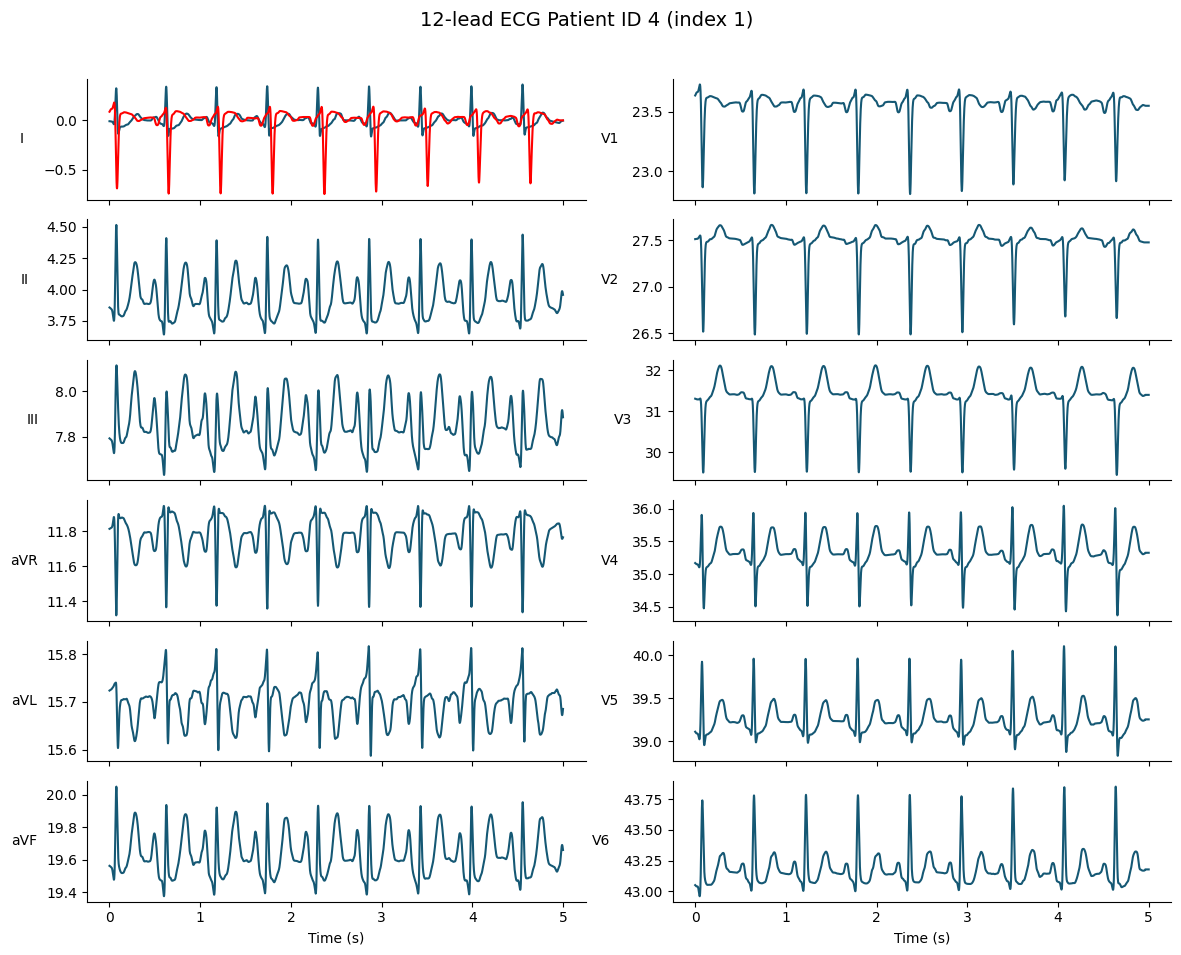

In [24]:
plot_12lead_for_patient(4, aligned_signals, tabular_data_Batch_01, fs=1000)